## Assignment 8
The goal of this lab is to examine and experiment with several techniques related to influence analysis
in complex networks. Influence is defined between two users and represents how
possible is for a user to adapt the behavior or copy the action of another user. 

We will first introduce the diffusion model which can be used to simulate a spreading process that takes place over the network.
 
Subsequently, we will utilize the structure of the network to identify influencers based in a heuristic manner.

Finally, we will examine the algorithmic solution to the problem of influence maximization,
which is choosing the optimum nodes to maximize the spread of information, and compare it with
the heuristic approach based on the simulations.

We will again rely on the network sciecne dataset for our use case. The following questions can be answered with the help of networkx and NDlib. You may also use other packages to deal with the problem. Please answer the following questions on the networks you have and submit your executable code.

In [73]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import ndlib.models.epidemics.IndependentCascadesModel as ICM
import ndlib.models.ModelConfig as mc
from pprint import pprint


In [2]:
path = ""

In [3]:
# download a file from a url 
import requests

def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)

download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=path+"netscience.gml")

In [27]:
# Read the data and show the basic information
graph = nx.read_gml("netscience.gml")

print("Graph Information:")
print(nx.info(graph))


print("\n5 Sample nodes:")
nodes_list = list(graph.nodes(data=True))  # 'data=True' to include attributes

print(nodes_list[:5])

Graph Information:
Graph with 1589 nodes and 2742 edges

5 Sample nodes:
[('ABRAMSON, G', {}), ('KUPERMAN, M', {}), ('ACEBRON, J', {}), ('BONILLA, L', {}), ('PEREZVICENTE, C', {})]


**(a)** We will first create a method to evaluate our chosen seeds, based on epidemic simulation. As a means for evaluation, we use the Independent Cascade model, to compute the number of influenced nodes during an influence spread over the network. 
This model assumes that a node v has only one chance to influence each of its neighbors u based on the probability `p v,u` . 
We define the model's parameters (threshold=0.01) based on common approaches in the literature, and run the epidemic through 10 steps in order to get an approximation and retreive fast results (in normal circumstances it is 10 thousand).


In terms of implementation we will define a function $simulate\_spreading$ that performs the simulation using the IndependentCascadeModel and ModelConfig from NDlib.
More specficially, we have to loop through the edges and add a variable named "threshold" that resembles the probability of influencing a node's neighbors (set to $0.01$ as is common in the literature for dense graphs), using the function $add\_edge\_configuration$.


In [51]:
def simulate_spreading(G, seed_set, sim=10, num_steps=5, threshold=0.01):
    """
    Simulates the influence spread on a graph using the Independent Cascade Model from NDlib.

    Parameters:
    - G (networkx.Graph): Input graph.
    - seed_set (list): List of seed nodes to start the spread.
    - sim (int): Number of simulation runs to average the result.
    - num_steps (int): Number of steps in each simulation.
    - threshold (float): Propagation probability for each edge.

    Returns:
    - float: Average number of influenced nodes after all simulations.
    """
    total_influenced = 0
    
    for _ in range(sim):
        # Initialize the Independent Cascade Model
        model = ICM(G)
        config = mc.Configuration()

        # Add seed nodes to the configuration
        config.add_model_initial_configuration("Infected", seed_set)

        # Add thresholds to edges
        for edge in G.edges():
            config.add_edge_configuration("threshold", edge, threshold)

        # Set the configuration
        model.set_initial_status(config)

        # Simulate for the specified number of steps
        iterations = model.iteration_bunch(num_steps)

        # Track influenced nodes
        influenced_nodes = set()
        for iteration in iterations:
            # Extract nodes with status '1' (infected)
            infected_nodes = [node for node, status in iteration["status"].items() if status == 1]
            influenced_nodes.update(infected_nodes)

        total_influenced += len(influenced_nodes)

    # Return the average number of influenced nodes
    return total_influenced / sim


In [81]:
for i in range(10):
    seed_nodes = list(graph.nodes)[:i+1]  # Select first i+1 nodes 
    total_influenced = simulate_spreading(graph, seed_nodes, sim=10, num_steps=5, threshold=0.1)   # Higher threshold for spread
    pprint(f"Iteration {i}, Seed Nodes: {seed_nodes}, Average Influenced Nodes: {total_influenced}")
    print('----------------------------------------------------------------------------------')

"Iteration 0, Seed Nodes: ['ABRAMSON, G'], Average Influenced Nodes: 1.3"
----------------------------------------------------------------------------------
("Iteration 1, Seed Nodes: ['ABRAMSON, G', 'KUPERMAN, M'], Average Influenced "
 'Nodes: 2.4')
----------------------------------------------------------------------------------
("Iteration 2, Seed Nodes: ['ABRAMSON, G', 'KUPERMAN, M', 'ACEBRON, J'], "
 'Average Influenced Nodes: 3.2')
----------------------------------------------------------------------------------
("Iteration 3, Seed Nodes: ['ABRAMSON, G', 'KUPERMAN, M', 'ACEBRON, J', "
 "'BONILLA, L'], Average Influenced Nodes: 5.2")
----------------------------------------------------------------------------------
("Iteration 4, Seed Nodes: ['ABRAMSON, G', 'KUPERMAN, M', 'ACEBRON, J', "
 "'BONILLA, L', 'PEREZVICENTE, C'], Average Influenced Nodes: 6.0")
----------------------------------------------------------------------------------
("Iteration 5, Seed Nodes: ['ABRAMSON, G',

**(b)** Compute K-core score:  Given our undirected network G, C k is defined as the k-core subgraph of G if it is a maximal connected subgraph in which all nodes have degree at least k. Then, each node v ∈ V has a core number c(v) = k, if it belongs to a k-core but not to a (k + 1)-core. The cohesion of subgraphs increases as k increases. Let us denote as C the set of nodes with the maximum core number k\_max. Compute the top 20 nodes in terms of the k-core they belong to and simulate their spreading.

In [ ]:
def get_top_k_core_nodes(G, top_n):
    """
    Returns the top n nodes with the highest core number (k-core).
    
    Parameters:
    - G (networkx.Graph): The input graph.
    - top_n (int): The number of top nodes to select based on their core number.
    
    Returns:
    - list: A list of the top n nodes with the highest core number.
    """
    # Compute the core number for each node
    core_numbers = nx.core_number(G)
    
    # Sort nodes by core number in descending order
    sorted_nodes = sorted(core_numbers.items(), key=lambda x: x[1], reverse=True)
    
    # Extract the top_n nodes based on core number
    top_nodes = [node for node, core in sorted_nodes[:top_n]]
    
    return top_nodes

def simulate_spreading_on_top_k_core_nodes(G, top_k_nodes, sim=10, num_steps=5, threshold=0.1):
    """
    Simulates the influence spread on the top nodes with the highest core number (top k-core).
    
    Parameters:
    - G (networkx.Graph): Input graph.
    - top_k_nodes (list): List of top nodes with the highest core number.
    - sim (int): Number of simulation runs.
    - num_steps (int): Number of steps in each simulation.
    - threshold (float): Propagation probability for each edge.
    
    Returns:
    - dict: A dictionary with the node and the average influenced nodes for each simulation.
    """
    results = {}
    for node in top_k_nodes:
        seed_nodes = [node]  # Start with the top node as the seed
        total_influenced = simulate_spreading(G, seed_nodes, sim=sim, num_steps=num_steps, threshold=threshold)
        results[node] = total_influenced
    return results

top_20_k_core_nodes = get_top_k_core_nodes(graph, top_n=20)


# Simulate the spreading for the top 20 nodes in the k-core
results = simulate_spreading_on_top_k_core_nodes(graph, top_20_k_core_nodes, sim=10, num_steps=5, threshold=0.1)

for node, influenced in results.items():
    print(f"Node: {node}, Average Influenced Nodes: {influenced}")

Node: GIOT, L, Average Influenced Nodes: 13.5
Node: UETZ, P, Average Influenced Nodes: 11.8
Node: CAGNEY, G, Average Influenced Nodes: 6.7
Node: MANSFIELD, T, Average Influenced Nodes: 10.3
Node: JUDSON, R, Average Influenced Nodes: 11.8
Node: KNIGHT, J, Average Influenced Nodes: 8.5
Node: LOCKSHON, D, Average Influenced Nodes: 10.6
Node: NARAYAN, V, Average Influenced Nodes: 9.9
Node: SRINIVASAN, M, Average Influenced Nodes: 10.2
Node: POCHART, P, Average Influenced Nodes: 10.5
Node: QURESHIEMILI, A, Average Influenced Nodes: 10.0
Node: LI, Y, Average Influenced Nodes: 10.7
Node: GODWIN, B, Average Influenced Nodes: 13.2
Node: CONOVER, D, Average Influenced Nodes: 12.2
Node: KALBFLEISCH, T, Average Influenced Nodes: 9.6
Node: VIJAYADAMODAR, G, Average Influenced Nodes: 13.5
Node: YANG, M, Average Influenced Nodes: 10.1
Node: JOHNSTON, M, Average Influenced Nodes: 8.2
Node: FIELDS, S, Average Influenced Nodes: 10.2
Node: ROTHBERG, J, Average Influenced Nodes: 12.4


**(c)** Implement Greedy IM: Influence Maximization is the problem that lies in the heart of influence analysis and addresses how to find a set of nodes, such that if they start a diffusion, the number of infected nodes in the network (influenced spread) will be maximized. It has a broad range of applications, from viral marketing, which was the initial motivation for the problem, to epidemiological containment and political campaign management.
The problem can be formulated as follows: given a social network, a diffusion model with some parameters and a number k, find a seed set S $\subset$ V of size k such that the influence spread is maximized.  We will use the well known method from Kempe et al.[ [1](https://dl.acm.org/doi/pdf/10.1145/956750.956769?casa_token=tkl-2BIJoXIAAAAA:SD8O7LcvEPGyGAdv8cHEwSqgn3Jz0UeHvpRK3-xYB2Z9C7gy-iOQpeHoFqOWzDMfAskBgVzYrpzS)] that is based on the fact that the function of the influence spread under the IC and LT models is monotone non-decreasing and submodular, which gives a  $(1-1/e)$ approximation ratio to the optimal.

To simplify and speed up the implementation to less then a minute, we are going to use only one simple simulation based on the function defined above. Moreover, we will reduce the search space of the algorithm by giving as an input a set of selected nodes to search on. To find a shorter set of such nodes, you can use the filter\_graph function below, that removes nodes under a certain degree, and set an appropriate threshold e.g. 3. We utilize these shortcuts because we need to make the algorithm run in time for the lab. You are encouraged to experiment further in your own time with an implementation that matches more the original algorithm, mainly in order to get a firm understanding of the computational demand of influence maximization.

In [120]:
def filter_graph(G,threshold):
    G_ = G.copy()
    to_remove = [i for i in G_.nodes() if G_.degree(i) < threshold]
    G_.remove_nodes_from(to_remove)
    print("Removed "+str(len(to_remove))+" of "+str(len(G.nodes()))+" nodes")
   
    return G_

In [ ]:
import random

def greedy_algorithm(G, selected_nodes, size, sim):
    """
    Greedy influence maximization algorithm for a subset of nodes (Kempe et al., 2003)
    
    Parameters:
    - G (networkx.Graph): The input graph.
    - selected_nodes (list): List of nodes to search over for the best seed set.
    - size (int): The size of the seed set (k).
    - sim (int): The number of simulation runs to estimate influence spread.
    
    Returns:
    - list: A list of selected seed nodes.
    """
    seed_set = []  
    remaining_nodes = selected_nodes.copy() 
    total_influenced = []  
    
    for _ in range(size):
        influence_spread = {}  
        
        for node in remaining_nodes:
            current_seed_set = seed_set + [node]
            influence = simulate_spreading(G, current_seed_set, sim=sim, num_steps=5, threshold=0.1)
            influence_spread[node] = influence
        
        best_node = max(influence_spread, key=influence_spread.get)
        
        seed_set.append(best_node)
        
        remaining_nodes.remove(best_node)
        
        print(f"Selected node: {best_node}, Influence spread: {influence_spread[best_node]}")
        
    return seed_set


Removed 793 of 1589 nodes
Selected node: UETZ, P, Influence spread: 15.0
Selected node: JEONG, H, Influence spread: 21.0
Selected node: KLEINBERG, J, Influence spread: 27.8
Selected node: ALON, U, Influence spread: 31.0
Selected node: WELLMAN, B, Influence spread: 38.4
Final seed set: ['UETZ, P', 'JEONG, H', 'KLEINBERG, J', 'ALON, U', 'WELLMAN, B']


**(d)** Plot the spreading of k-core and greedy IM for a seed set of 20 to compare them.

Removed 793 of 1589 nodes
Selected node: JUDSON, R, Influence spread: 13.6
Selected node: ALON, U, Influence spread: 19.6
Selected node: JEONG, H, Influence spread: 26.5
Selected node: BENJACOB, E, Influence spread: 32.9
Selected node: WEULE, M, Influence spread: 34.5
Selected node: WEIL, B, Influence spread: 38.5
Selected node: VALLONE, A, Influence spread: 40.8
Selected node: KRAPIVSKY, P, Influence spread: 41.7
Selected node: KUMAR, R, Influence spread: 45.7
Selected node: STAUFFER, D, Influence spread: 46.7
Selected node: SRINIVASAN, M, Influence spread: 49.9
Selected node: AMARAL, L, Influence spread: 53.2
Selected node: VALVERDE, S, Influence spread: 55.3
Selected node: MURRAY, A, Influence spread: 57.6
Selected node: MUTH, S, Influence spread: 59.7
Selected node: GERBER, G, Influence spread: 65.9
Selected node: CALDARELLI, G, Influence spread: 66.3
Selected node: MAY, R, Influence spread: 69.6
Selected node: LLAS, M, Influence spread: 71.7
Selected node: KLOVDAHL, A, Influence s

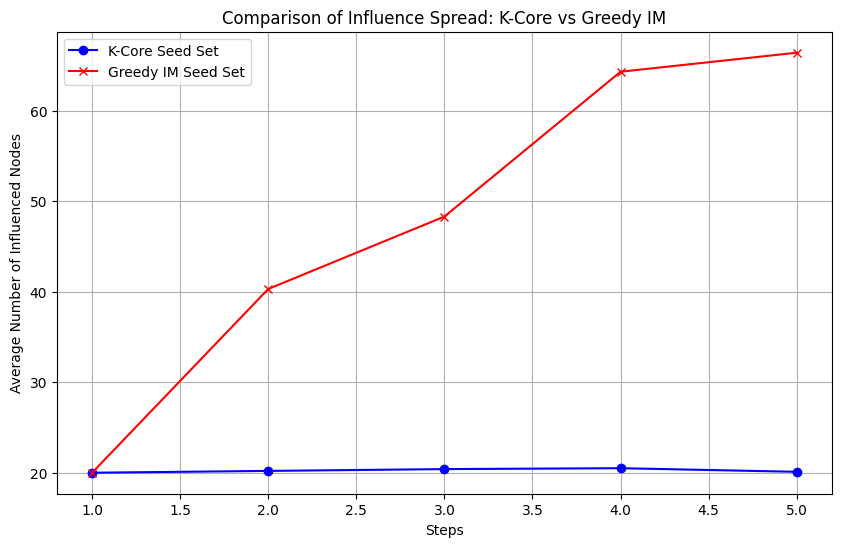

In [ ]:
def plot_spreading_comparison(G, sim=10, num_steps=5, threshold=0.1):
    """
    Compares the spreading of influence using k-core nodes and Greedy IM.
    
    Parameters:
    - G (networkx.Graph): The input graph.
    - sim (int): Number of simulation runs.
    - num_steps (int): Number of steps in the simulation.
    - threshold (float): Propagation probability for each edge.
    """
    
    # Get the top 20 nodes using k-core
    k_max_nodes = get_k_max_nodes(G)[:20]
    
    # Run Greedy IM to select the top 20 nodes
    filtered_graph = filter_graph(G, threshold=3)
    selected_nodes_for_greedy = list(filtered_graph.nodes)
    greedy_seed_set = greedy_algorithm(filtered_graph, selected_nodes_for_greedy, size=20, sim=sim)
    
    # Simulate the spreading for k-core nodes
    k_core_influenced = []
    for step in range(1, num_steps + 1):
        influenced_nodes = simulate_spreading(G, k_max_nodes, sim=sim, num_steps=step, threshold=threshold)
        k_core_influenced.append(influenced_nodes)

    # Simulate the spreading for Greedy IM nodes
    greedy_influenced = []
    for step in range(1, num_steps + 1):
        influenced_nodes = simulate_spreading(G, greedy_seed_set, sim=sim, num_steps=step, threshold=threshold)
        greedy_influenced.append(influenced_nodes)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_steps + 1), k_core_influenced, label="K-Core Seed Set", marker='o', color='blue')
    plt.plot(range(1, num_steps + 1), greedy_influenced, label="Greedy IM Seed Set", marker='x', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Average Number of Influenced Nodes')
    plt.title('Comparison of Influence Spread: K-Core vs Greedy IM')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_spreading_comparison(graph, sim=10, num_steps=5, threshold=0.1)
